# imports e configurações

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning

sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


# Carga e limpeza inicial

In [62]:
df = pd.read_csv('./data/mama.csv')

df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

# transformação do Alvo (Target)
# M (Maligno) -> 1
# B (Benigno) -> 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

print(f"dataset carregado: {df.shape[0]} linhas e {df.shape[1]} colunas.")
df.head()

dataset carregado: 569 linhas e 31 colunas.


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Análise de correlação

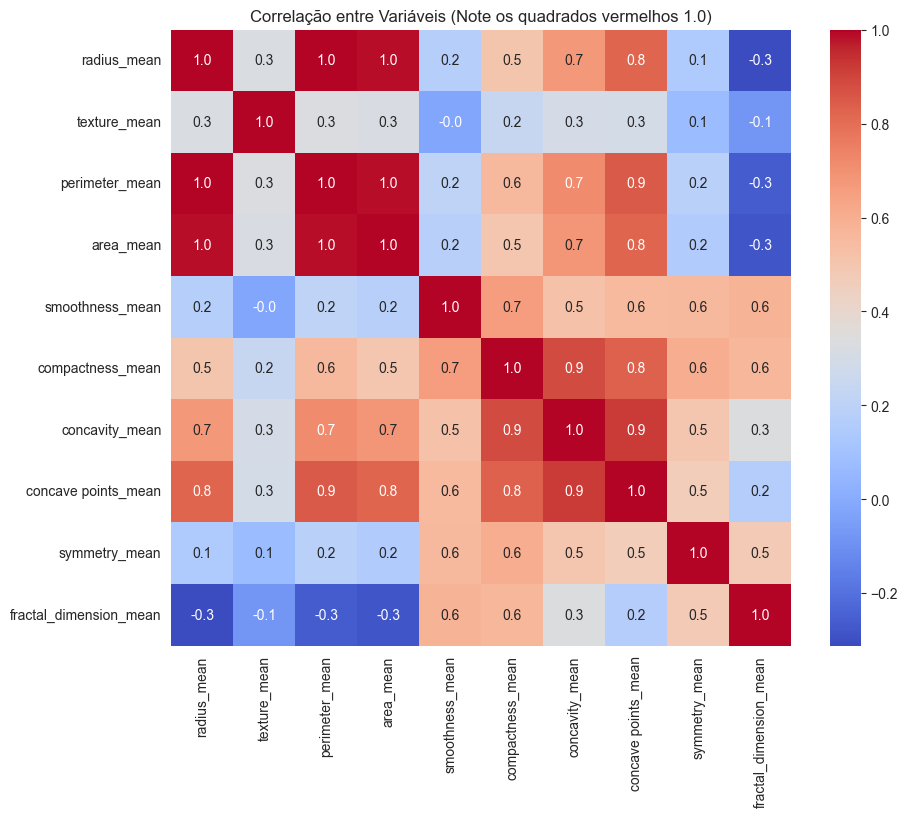

In [63]:
# gerar o Heatmap para identificar redundância
plt.figure(figsize=(10, 8))
# vamos olhar apenas as primeiras 10 variáveis  para não poluir
sns.heatmap(df.iloc[:, 1:11].corr(), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlação entre Variáveis (Note os quadrados vermelhos 1.0)")
plt.show()

# Feature selection

In [64]:
# removendo variáveis altamente correlacionadas (Geometricamente redundantes)
# mantemos 'radius' e removemos 'area', 'perimeter', etc.
colunas_redundantes = [
    'perimeter_mean', 'area_mean', 'compactness_mean', 'concave points_mean',
    'perimeter_se',   'area_se',   'compactness_se',   'concave points_se',
    'perimeter_worst','area_worst','compactness_worst','concave points_worst'
]

df_limpo = df.drop(columns=colunas_redundantes, errors='ignore')

X = df_limpo.drop(columns=['diagnosis'])
y = df_limpo['diagnosis']

print(f"colunas reduzidas de {df.shape[1]} para {df_limpo.shape[1]}.")
print("colunas mantidas:", X.columns.tolist())

colunas reduzidas de 31 para 19.
colunas mantidas: ['radius_mean', 'texture_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'smoothness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']


# O experimento (normalizados vs não normalizados)

In [65]:
# separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("TESTE DE ESTRESSE: Eficiência do Modelo")

# Modelo 1: Sem Normalização (Bruto)
modelo_bruto = LogisticRegression(max_iter=10, solver='liblinear', random_state=42)
modelo_bruto.fit(X_train, y_train)
acc_bruta = modelo_bruto.score(X_test, y_test)

# Modelo 2: Com Normalização (Pipeline)
modelo_norm = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=10, solver='liblinear', random_state=42)
)
modelo_norm.fit(X_train, y_train)
acc_norm = modelo_norm.score(X_test, y_test)

print(f"Acurácia SEM Normalização: {acc_bruta * 100:.2f}%")
print(f"Acurácia COM Normalização: {acc_norm * 100:.2f}%")
print(f"Ganho de Eficiência: {(acc_norm - acc_bruta)*100:.1f}%")

TESTE DE ESTRESSE: Eficiência do Modelo
Acurácia SEM Normalização: 95.61%
Acurácia COM Normalização: 98.25%
Ganho de Eficiência: 2.6%


# Modelo definitivo e validação cruzada

In [66]:
print("treinamento do modelo final")

# Pipeline Definitivo (Scaler + LogReg com tempo suficiente)
modelo_final = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
)

# validação cruzada (K-Fold) para provar robustez
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(modelo_final, X, y, cv=cv, scoring='accuracy')

print(f"Acurácia Média (10-Fold): {scores.mean()*100:.2f}%")
print(f"Desvio Padrão: +/- {scores.std()*100:.2f}%")

# treinar no conjunto de treino oficial para gerar os gráficos
modelo_final.fit(X_train, y_train)
y_pred = modelo_final.predict(X_test)

treinamento do modelo final
Acurácia Média (10-Fold): 97.37%
Desvio Padrão: +/- 1.41%


# Visualização dos resultados

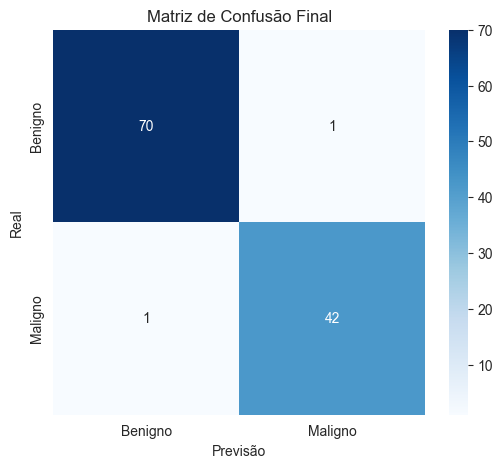

C:\Users\spsam\AppData\Local\Temp\ipykernel_27184\1000982152.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Peso', y='Exame', data=df_imp, palette='viridis')


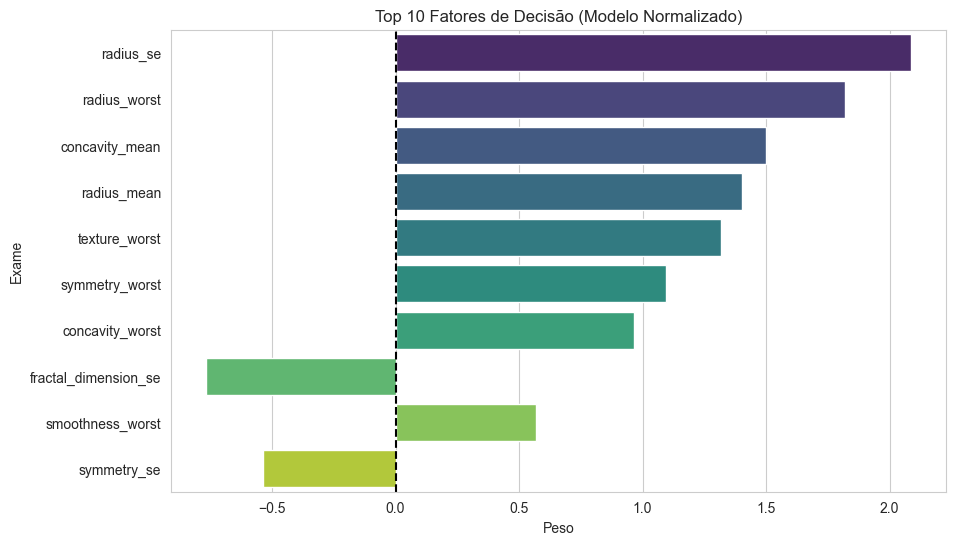

In [67]:
# matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusão Final')
plt.xlabel('Previsão'); plt.ylabel('Real')
plt.savefig('grafico_matriz.png')
plt.show()

# Feature Importance 
# extraindo pesos do Pipeline
pesos = modelo_final.named_steps['logisticregression'].coef_[0]
df_imp = pd.DataFrame({'Exame': X.columns, 'Peso': pesos})
df_imp['Absoluto'] = df_imp['Peso'].abs()
df_imp = df_imp.sort_values(by='Absoluto', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Peso', y='Exame', data=df_imp, palette='viridis')
plt.title('Top 10 Fatores de Decisão (Modelo Normalizado)')
plt.axvline(x=0, color='black', linestyle='--')
plt.savefig('grafico_pesos.png') 
plt.show()

In [68]:
# VERIFICAÇÃO DE OVERFITTING

# Calcular a nota nos dados que ele JÁ VIU (Treino)
acc_treino = modelo_final.score(X_train, y_train)

# Calcular a nota nos dados que ele NUNCA VIU (Teste)
acc_teste = modelo_final.score(X_test, y_test)

print(f"Acurácia no Treino: {acc_treino * 100:.2f}%")
print(f"Acurácia no Teste:  {acc_teste * 100:.2f}%")

# Calcular a diferença (Gap)
gap = acc_treino - acc_teste

if gap > 0.05: # se a diferença for maior que 5%
    print(f"ALERTA: Possível Overfitting! O modelo é {gap*100:.1f}% melhor no treino.")
elif gap < -0.05:
    print("Estranho: O modelo foi melhor no teste (pode ser sorte na divisão dos dados).")
else:
    print(f"SUCESSO: O modelo é estável! A diferença é de apenas {gap*100:.1f}%.")

Acurácia no Treino: 98.46%
Acurácia no Teste:  98.25%
SUCESSO: O modelo é estável! A diferença é de apenas 0.2%.


c:\Users\spsam\Documentos\projetos_si\regressao-logistica-cancer-mama\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


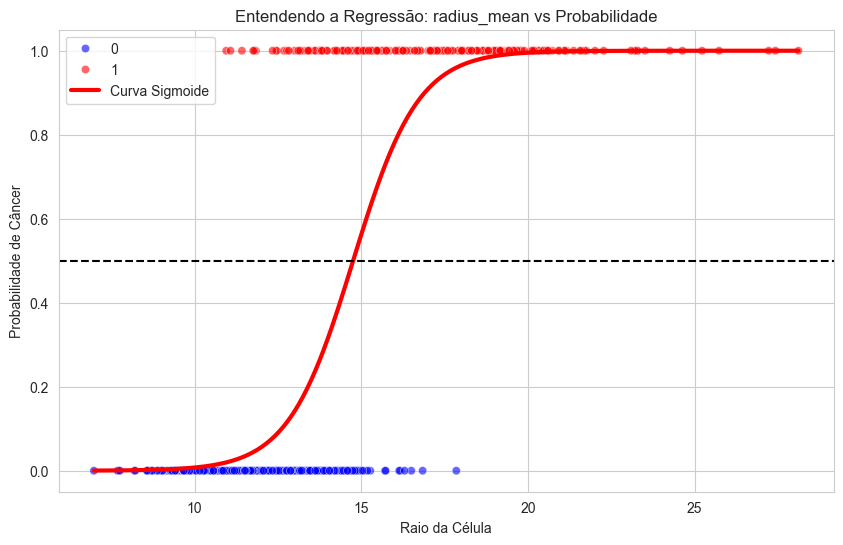

In [ ]:
# %%
# BÔNUS: Visualização da Curva Sigmoide

# Treinamos um modelo simples só com o RAIO para mostrar a curva S didática
feature_col = 'radius_mean'
X_visual = df[[feature_col]] 
y_visual = df['diagnosis']

clf_visual = LogisticRegression()
clf_visual.fit(X_visual, y_visual)

# Criar pontos para a linha vermelha (Matemática)
# Ajuste técnico: .values para garantir que são números e reshape para formato 2D
x_min, x_max = X_visual[feature_col].min(), X_visual[feature_col].max()
x_range = np.linspace(x_min, x_max, 500).reshape(-1, 1)

# Prever a probabilidade para esses pontos
y_prob = clf_visual.predict_proba(x_range)[:, 1]

plt.figure(figsize=(10, 6))
# Bolinhas (Pacientes)
sns.scatterplot(x=X_visual[feature_col], y=y_visual, hue=y_visual, palette={0: 'blue', 1: 'red'}, alpha=0.6)

# Curva S
plt.plot(x_range, y_prob, color='red', linewidth=3, label='Curva Sigmoide')

# Linha de corte
plt.axhline(0.5, color='black', linestyle='--')

plt.title(f'Entendendo a Regressão: {feature_col} vs Probabilidade')
plt.ylabel('Probabilidade de Câncer'); plt.xlabel('Raio da Célula')
plt.legend(loc='center right')
plt.savefig('grafico_sigmoide.png')
plt.show()